In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
file_path = '/kaggle/input/original-hiring-dataset/Hiring_dataset.csv'
df = pd.read_csv(file_path)

num_features = df.select_dtypes(exclude=['object']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())
                        ])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_features),
                                               ('cat', cat_pipeline, cat_features)])

X = preprocessor.fit_transform(df)

In [3]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'ExperienceYears', 'PreviousCompanies',
                                  'DistanceFromCompany', 'InterviewScore',
                                  'SkillScore', 'PersonalityScore',
                                  'HiringDecision']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'EducationLevel',
                                  'RecruitmentStrategy'])])

In [4]:
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor.shape

torch.Size([1500, 17])

In [5]:
#Autoencoder and decoder model for word emedding
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        embeddings = self.encoder(x)
        reconstructed = self.decoder(embeddings)
        return reconstructed, embeddings

In [6]:
# Initialize model and Optimizers
input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 80
batch_size = 32

In [7]:
loss_history = []
test_loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for i in range(0, len(X_tensor), batch_size):
        x_batch = X_tensor[i:i + batch_size]

        optimizer.zero_grad()
        reconstructed, _ = model(x_batch)
        
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (len(X_tensor) / batch_size)
    loss_history.append(avg_loss)
    

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 10/80, Loss: 0.0452
Epoch 20/80, Loss: 0.0210
Epoch 30/80, Loss: 0.0150
Epoch 40/80, Loss: 0.0124
Epoch 50/80, Loss: 0.0113
Epoch 60/80, Loss: 0.0078
Epoch 70/80, Loss: 0.0084
Epoch 80/80, Loss: 0.0079


In [8]:
# Save the model
# torch.save(model.state_dict(), 'candidate_autoencoder.pth')

In [9]:
#Extract embeddings and # Convert embeddings to numpy array
with torch.no_grad():
    _, embeddings = model(X_tensor)

embeddings_np = embeddings.numpy()
embeddings_np.shape

(1500, 32)

In [10]:
#Recommend top N candidates based on cosine similarity.
#cosine similarity
# Sort by similarity

def recommend_candidates(query_index, embeddings, top_n=5):
    similarities = cosine_similarity([embeddings[query_index]], embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n + 1]  # Include self in top candidates
    top_indices = [idx for idx in top_indices if idx != query_index][:top_n]  # Exclude self-match

    # Display results
    print(f"\nTop {top_n} Candidates for Candidate {query_index}:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Candidate {idx} - Similarity: {similarities[idx]:.4f}")

recommend_candidates(0, embeddings_np, top_n=5)


Top 5 Candidates for Candidate 0:
1. Candidate 198 - Similarity: 0.9692
2. Candidate 171 - Similarity: 0.9063
3. Candidate 784 - Similarity: 0.8671
4. Candidate 836 - Similarity: 0.8669
5. Candidate 1139 - Similarity: 0.8643


In [11]:
def match_candidate(sample, preprocessor, model, embeddings_np, top_n=5):
    """
    Match a sample candidate with the most similar candidates from the dataset.
    Display the full candidate details along with their similarity scores.
    """
    # Preprocess the sample using the same preprocessor
    sample_df = pd.DataFrame([sample], columns=df.columns)
    sample_processed = preprocessor.transform(sample_df)
    
    # Convert to PyTorch tensor
    sample_tensor = torch.tensor(sample_processed, dtype=torch.float32)

    # Extract the embedding for the new candidate
    model.eval()
    with torch.no_grad():
        _, sample_embedding = model(sample_tensor)
    
    # Compute cosine similarity with existing embeddings
    sample_embedding_np = sample_embedding.numpy()
    similarities = cosine_similarity(sample_embedding_np, embeddings_np)[0]

    # Sort and display top N matches
    top_indices = np.argsort(similarities)[::-1][:top_n]

    print(f"\n Top {top_n} Similar Candidates for the Sample:")
    
    for i, idx in enumerate(top_indices):
        similarity_score = similarities[idx]
        candidate_details = df.iloc[idx].to_dict()
        
        print(f"\n {i+1}. Candidate {idx} - Similarity: {similarity_score:.4f}")
        
        # Print the full candidate details
        for key, value in candidate_details.items():
            print(f"    {key}: {value}")

In [12]:
# Sample input
sample_candidate = {
    'Age': 22,
    'Gender': 'Male',
    'EducationLevel': 'Phd',
    'ExperienceYears': 4,
    'PreviousCompanies': 5,
    'DistanceFromCompany': 16,
    'InterviewScore': 68,
    'SkillScore': 85,
    'PersonalityScore': 43,
    'RecruitmentStrategy': 'Moderate',
    'HiringDecision':0
}

# Match the sample candidate with the dataset
match_candidate(sample_candidate, preprocessor, model, embeddings_np, top_n=5)


 Top 5 Similar Candidates for the Sample:

 1. Candidate 517 - Similarity: 0.9664
    Age: 22
    Gender: Male
    EducationLevel: Bachelor's (Type 2)
    ExperienceYears: 4
    PreviousCompanies: 5
    DistanceFromCompany: 16
    InterviewScore: 68
    SkillScore: 84
    PersonalityScore: 43
    RecruitmentStrategy: Moderate
    HiringDecision: 0

 2. Candidate 745 - Similarity: 0.8926
    Age: 22
    Gender: Male
    EducationLevel: Master's
    ExperienceYears: 5
    PreviousCompanies: 4
    DistanceFromCompany: 10
    InterviewScore: 61
    SkillScore: 89
    PersonalityScore: 61
    RecruitmentStrategy: Moderate
    HiringDecision: 0

 3. Candidate 1358 - Similarity: 0.8689
    Age: 24
    Gender: Male
    EducationLevel: Bachelor's (Type 2)
    ExperienceYears: 3
    PreviousCompanies: 5
    DistanceFromCompany: 2
    InterviewScore: 11
    SkillScore: 99
    PersonalityScore: 40
    RecruitmentStrategy: Moderate
    HiringDecision: 0

 4. Candidate 1127 - Similarity: 0.8353
   

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


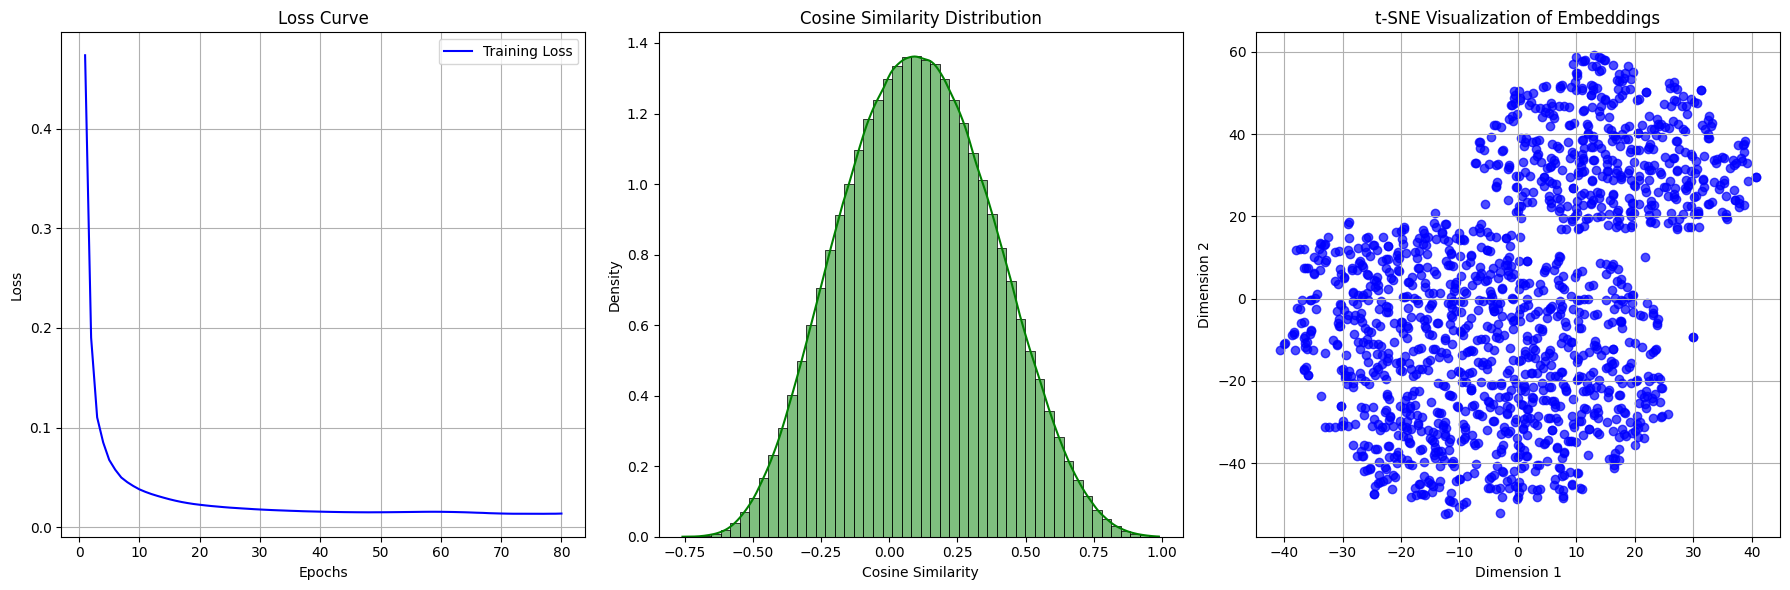

In [13]:
from sklearn.manifold import TSNE
# 1. Plotting the Loss Curve  # 2. Cosine Similarity Distribution  # 3. t-SNE Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the size as needed
axs[0].plot(range(1, epochs + 1), loss_history, label='Training Loss', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Curve')
axs[0].grid(True)
axs[0].legend()

similarities = cosine_similarity(embeddings_np)
sim_scores = similarities[np.triu_indices_from(similarities, k=1)]
sns.histplot(sim_scores, bins=50, kde=True, color='green', stat='density', ax=axs[1])
axs[1].set_title('Cosine Similarity Distribution')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_ylabel('Density')

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)
axs[2].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)
axs[2].set_title('t-SNE Visualization of Embeddings')
axs[2].set_xlabel('Dimension 1')
axs[2].set_ylabel('Dimension 2')
axs[2].grid(True)

plt.tight_layout()
plt.show()